In [3]:
import numpy as np
import openai
import json
import os
import random
import itertools
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count
from collections import defaultdict
from scipy.stats import norm
## import some functions to make everything parallel
from AM_par_func import _sample_one_candidate_AM, _predict_llm_score_AM
your_OPENAI_API_key = "your key"

## 3D printing initial data generator

### Define initialization process (BO: random start, others: warmstarting)

In [ ]:
def random_initialize(seed=250410, n_init=2):
    random.seed(seed)
    # Define ranges for the five parameters
    nozzle_temp = np.arange(220, 261, 1)  # integers, no need to round
    z_hop_height = np.round(np.arange(0.0, 1.01, 0.1), 1)  # round to 1 decimal
    coasting_volume = np.round(np.arange(0.02, 0.11, 0.01), 2)  # round to 2 decimals
    retraction_distance = np.round(np.arange(1.0, 10.1, 1.0), 1)  # still 1 decimal for consistency
    outer_wall_wipe_distance = np.round(np.arange(0.0, 1.01, 0.1), 1)  # round to 1 decimal
    # Create the full grid of feasible combinations
    grid = list(itertools.product(
        nozzle_temp,
        z_hop_height,
        coasting_volume,
        retraction_distance,
        outer_wall_wipe_distance
    ))

    # Randomly sample n_init points
    random_points = random.sample(grid, n_init)
    return random_points

if not os.getenv('OPENAI_API_KEY'):
    os.environ['OPENAI_API_KEY'] = your_OPENAI_API_key

# this function controls the input and the output of OpenAI API. We just need to prompt in the prompt and can get the results        
def query_llm(prompt, model="gpt-4o", max_tokens=4000):
    messages = [
    {"role": "system", "content": "You are an AI assistant that helps me optimizing the 3D manufacturing process by controling parameters."},
    {"role": "user", "content": prompt}
    ]
    client = openai.OpenAI()
    response = client.chat.completions.create(
        model=model,
        messages=messages,
        max_tokens=max_tokens
    )
        
    return response.choices[0].message.content

# LLMBO and LLAMBO share the same warmstarting process
def warmstarting_initialize(num_warmstart=2):
    # rpompt used for warmstarting
    prompt = f"""
    You are assisting with process planning for 3D printing a simple part using Overture PETG filament on an Ender 3 Pro in a room-temperature environment (around 22°C). 
    The objective is to reduce **stringing** as much as possible, using knowledge of PETG printing behavior.

    You are allowed to adjust **only five slicing parameters**:
    1. **Nozzle Temperature**: Range 220–260°C (step: 1°C)
    2. **Z Hop Height**: Range 0.1–1.0 mm (step: 0.1 mm)
    3. **Coasting Volume**:	0.02–0.1 mm³ (step: 0.01 mm³)
    4. **Retraction Distance**: 1.0–10.0 mm (step: 1 mm)
    5. **Outer Wall Wipe Distance**: 0.0–1.0 mm (step: 0.1 mm)
    
    These slicing settings are fixed:
    - Retraction Speed = 60 mm/s
    - Travel Speed = 178 mm/s
    - Fan Speed = 60 %
    
    Other slicing settings are set to be the software's default values.
    After each print, stringing is measured via an image-based algorithm, returning a percentage between 0 and 100%.
    You must now propose {num_warmstart} promising combinations of Nozzle Temperature and Z Hop that are likely to minimize stringing, based on your understanding of PETG behavior (e.g., lower nozzle temps reduce oozing, moderate Z hop avoids drag).
    **Format your answer strictly as a valid JSON list of 5-dimensional vectors.** Each vector should be: [Nozzle Temperature (°C), Z Hop Height (mm), Coasting Volume (mm³), Retraction Distance (mm), Outer Wall Wipe Distance (mm)]. 
    Do not include any explanations, labels, formatting, or extra text like json.
    """
        
    while True:
        llm_output = query_llm(prompt)
        try:
            warmstart_points = json.loads(llm_output)
            return warmstart_points
        except:
            continue


## Example usage: Initialize in just one line code!!

In [ ]:
warmstarting_initialize()

[[235, 0.4, 0.05, 6, 0.5], [230, 0.3, 0.04, 7, 0.4]]

## Create a dictionary to store the history for all methods

In [ ]:
## just an example
all_history = {
    "LLAMBO-L": [
        ((235, 0.3, 0.06, 4, 0.3), 29.04),
        ((245, 0.5, 0.08, 5, 0.5), 27.5),
        ((240, 0.2, 0.04, 6, 0.4), 12.6),
        ((230, 0.7, 0.07, 3, 0.4), 6.03),
        ((230, 0.8, 0.09, 6, 0.3), 25.68),
        ((225, 0.9, 0.05, 7, 0.2), 44.34),
        ((235, 0.4, 0.05, 7, 0.4), 85),
        ((225, 0.5, 0.03, 4, 0.6), 16),
        ((225, 0.6, 0.08, 5, 0.6), 22.47)
    ],
    "LLAMBO": [
        ((235, 0.3, 0.06, 4, 0.3), 29.04),
        ((245, 0.5, 0.08, 5, 0.5), 27.5),
        ((239, 0.4, 0.07, 5, 0.4), 48.49),
        ((256, 0.1, 0.03, 2, 0), 17.85),
        ((259, 0.2, 0.04, 3, 0.2), 28.43),
        ((258, 0.2, 0.03, 3, 0.3), 26.54),
        ((257, 0.9, 0.07, 6, 0.1), 81),
        ((254, 0.4, 0.05, 4, 0.4), 76),
        ((259, 0.2, 0.02, 4, 0.2), 25.8)
    ],
    "TRAISIENT": [
        ((235, 0.3, 0.06, 4, 0.3), 29.04),
        ((245, 0.5, 0.08, 5, 0.5), 27.5),
        ((230, 0.4, 0.07, 6, 0.4), 23.61),
        ((222, 0.5, 0.08, 9, 0.4), 6.66),
        ((220, 0.6, 0.09, 9, 0.5), 4.75),
        ((220, 0.7, 0.1, 10, 0.2), 12.06),
        ((220, 0.7, 0.07, 10, 0.7), 11.05),
        ((220, 0.6, 0.07, 10, 0.8), 8.79),
        ((220, 0.3, 0.1, 10, 0.7), 0.97)
    ],
    "BO": [
        ((249, 0.6, 0.09, 3, 0.4), 89.06),
        ((256, 0.2, 0.07, 3, 0.7), 43.28),
        ((257, 0.1, 0.07, 3, 0.7), 18.91),
        ((258, 0, 0.07, 3, 0.7), 15.9),
        ((259, 0, 0.07, 3, 0.7), 15.75),
        ((260, 0, 0.07, 3, 0.7), 12.18),
        ((260, 0, 0.07, 3, 0.8), 18.86),
        ((260, 0, 0.07, 1, 0.6), 14.76),
        ((260, 0, 0.05, 3, 0.6),16.8)
    ]
}

## LLAMBO_L process to generate the next design

In [5]:
# LLMBO sample the next-to-design point by prompting in historical data and problem context
def sample_candidate_points_LLAMBO_L(history):
    shuffled_history = history.copy()
    # permutate the history to make the results more diverse
    random.shuffle(shuffled_history)   
    history_str = "\n".join([f"(Nozzle Temperature, Z Hop Height, Coasting Volume, Retraction Distance, Outer Wall Wipe Distance): {h[0]}, Stringing percentage: {h[1]}" for h in shuffled_history])
    current_iter = len(history)-1
    prompt = f"""
        The following are past evaluations of the stringing percentage and their corresponding Nozzle Temperature and Z Hop values:    
        {history_str}

        You are allowed to adjust **only five slicing parameters**:
        1. **Nozzle Temperature**: Range 220–260°C (step: 1°C)
        2. **Z Hop Height**: Range 0.1–1.0 mm (step: 0.1 mm)
        3. **Coasting Volume**:	0.02–0.1 mm³ (step: 0.01 mm³)
        4. **Retraction Distance**: 1.0–10.0 mm (step: 1 mm)
        5. **Outer Wall Wipe Distance**: 0.0–1.0 mm (step: 0.1 mm)
    
        All other slicing settings are fixed:
        - Retraction Speed = 60 mm/s
        - Travel Speed = 178 mm/s
        - Fan Speed = 60 %

        Your goal is to recommend the next setting to evaluate that balances **exploration** and **exploitation**:
        - **Exploration** favors regions that are less-sampled or farther from existing evaluations.
        - **Exploitation** favors regions near previously low stringing percentages.
        You are on iteration {current_iter} out of 10.
        The ultimate objective is to find the global minimum stringing percentage. The ideal stringing percentage is 0%.
        
        **Instructions:**
        - Return only one  5-dimensional vector: [Nozzle Temperature (°C), Z Hop Height (mm), Coasting Volume (mm³), Retraction Distance (mm), Outer Wall Wipe Distance (mm)].
        - Ensure the values respect the allowed ranges and increments.
        - Respond with strictly valid **JSON format**.
        - Do **not** include any explanations, comments, or extra text like jason.
        """
    while True:
        response = query_llm(prompt, max_tokens=50).strip()
        return response

## Create LLAMBO process to generate the next-to-design point

In [6]:
# candidate sampling phase
def sample_candidate_points(history):
    best_y = min(history, key=lambda x: x[1])[1]
    worst_y = max(history, key=lambda x: x[1])[1]
    target_score = best_y - 0.1 * (best_y - worst_y)
    permuted_histories = []
    for _ in range(20):
        shuffled = history.copy()
        random.shuffle(shuffled)
        permuted_histories.append(shuffled)
    
    # Prepare args for parallel calls
    args_list = []
    for i, history_variant in enumerate(permuted_histories[:20]):
        history_str = "\n".join([f"(Nozzle Temperature, Z Hop Height, Coasting Volume, Retraction Distance, Outer Wall Wipe Distance): {h[0]}, Stringing percentage: {h[1]}" for h in history_variant])
        args_list.append((history_str, target_score))

    with Pool(min(cpu_count(), 20)) as pool:
        candidates = pool.map(_sample_one_candidate_AM, args_list)
    return candidates

# surrogate modeling phase
def surrogate_model(candidates, history):
    grid_results = {}  # Store the mean and the variance of the selected candidates

    # Prepare all tasks (candidate x permutation)
    permuted_histories = []

    for _ in range(20):
        shuffled = history.copy()
        random.shuffle(shuffled)
        permuted_histories.append(shuffled)
    
    tasks = []
    for x in candidates:
        for history_variant in permuted_histories[:20]:
            history_str = "\n".join([f"(Nozzle Temperature, Z Hop Height, Coasting Volume, Retraction Distance, Outer Wall Wipe Distance): {h[0]}, Stringing percentage: {h[1]}" for h in history_variant])
            tasks.append((x, history_str))

    # Run in parallel
    with Pool(min(cpu_count(), len(tasks))) as pool:
        results = pool.map(_predict_llm_score_AM, tasks)

    # Group results by candidate
    grouped_scores = defaultdict(list)
    for score, x_key in results:
        grouped_scores[x_key].append(score)

    # Store in grid_results
    for x_key, scores in grouped_scores.items():
        mean, std = np.mean(scores), np.std(scores)
        grid_results[x_key] = (mean, std)
    return grid_results

# here we set the problem as a minimization problem
def expected_improvement(mean, std, best_so_far, xi=0.01, minimize=True):
    if minimize:
        improvement = best_so_far - mean - xi
    else:
        improvement = mean - best_so_far - xi
    z = improvement / (std + 1e-9)
    ei = improvement * norm.cdf(z) + std * norm.pdf(z)
    return ei
    
def sample_candidate_points_LLAMBO(history):
    candidates = sample_candidate_points(history)
    grid_res = surrogate_model(candidates, history)
    
    best_candidate = None
    best_ei = -np.inf
    # go through the acquisition function to select the best candidate    
    for candidate in candidates:
        best_so_far = min(history, key=lambda x: x[1])[1] # compute the current best
        mean, std = grid_res.get(tuple(candidate), (None, None))
        ei = expected_improvement(mean, std, best_so_far)
            
        if ei > best_ei:
            best_ei = ei
            best_candidate = candidate
        
    return best_candidate

## Create BO process to generate the next design

In [7]:
import numpy as np
import torch
from botorch.models import SingleTaskGP
from botorch.acquisition import UpperConfidenceBound
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_mll

# surrogate modeling
def train_gp(history):
    # Apply normalization
    X = torch.tensor([normalize(x) for x, _ in history], dtype=torch.float64)
    Y = torch.tensor([[y] for _, y in history], dtype=torch.float64)  # Shape: (n, 1)
    gp = SingleTaskGP(X, Y)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll)
    return gp

# acquisition function maximization over feasible points
def normalize(x):

    nozzle = (x[0] - 220) / (260 - 220)
    zhop = (x[1] - 0) / (1.0 - 0)
    coasting = (x[2] - 0.02) / (0.1 - 0.02)
    retraction = (x[3] - 1.0) / (10.0 - 1.0)
    wipe = (x[4] - 0.0) / (1.0 - 0.0)

    return [nozzle, zhop, coasting, retraction, wipe]


def optimize_acqf_ucb_grid(model, beta):
    # Step 1: Create original grid
    nozzle_temp = np.arange(220, 261, 1)  # integers, no need to round
    z_hop_height = np.round(np.arange(0.0, 1.01, 0.1), 1)  # round to 1 decimal
    coasting_volume = np.round(np.arange(0.02, 0.11, 0.01), 2)  # round to 2 decimals
    retraction_distance = np.round(np.arange(1.0, 10.1, 1.0), 1)  # still 1 decimal for consistency
    outer_wall_wipe_distance = np.round(np.arange(0.0, 1.01, 0.1), 1)  # round to 1 decimal
    # Create the full grid of feasible combinations
    grid = list(itertools.product(
        nozzle_temp,
        z_hop_height,
        coasting_volume,
        retraction_distance,
        outer_wall_wipe_distance
    ))
    
    # Step 2: Normalize each point to the unit cube
    norm_grid = [normalize(x) for x in grid]
    X_norm = torch.tensor(norm_grid, dtype=torch.float64)  # Shape: (n_points, 2)

    # Step 3: Evaluate UCB
    ucb = UpperConfidenceBound(model, beta=beta)
    with torch.no_grad():
        ucb_values = ucb(X_norm.unsqueeze(1)).squeeze()  # Shape: (n_points,)
    
    # Step 4: Select best candidate in original space
    max_idx = torch.argmax(ucb_values)
    best_candidate = grid[max_idx]  # original, unnormalized point
    
    return best_candidate


def sample_candidate_points_BO(history):
    history_gp = [(x, 100 - y) for x, y in history]
    model = train_gp(history_gp)
    beta_t = np.log((len(history)+1)*2*np.pi**2/0.1*6)*2
    next_x = optimize_acqf_ucb_grid(model, beta=beta_t)
    return next_x

/Users/chih-yuchang/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Create LLINBO-Traisient process to generate the next-to-design point

In [8]:
def sample_candidate_points_Transient(history):
    p_t = 1 - 1 / (len(history)-1)
    if np.random.rand() < p_t:
        return sample_candidate_points_BO(history)
    else:
        return sample_candidate_points_LLAMBO_L(history)

## exanple usage

In [9]:
sample_candidate_points_Transient(all_history["TRAISIENT"])
sample_candidate_points_BO(all_history["BO"])
#sample_candidate_points_LLAMBO(all_history["LLAMBO"])
sample_candidate_points_LLAMBO_L(all_history["LLAMBO-L"])

/Users/chih-yuchang/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([86.1744], dtype=torch.float64), std = tensor([10.3039], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/chih-yuchang/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([72.7222], dtype=torch.float64), std = tensor([24.9268], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


'```json\n[230, 0.5, 0.05, 5, 0.4]\n```'

## visualizing the results

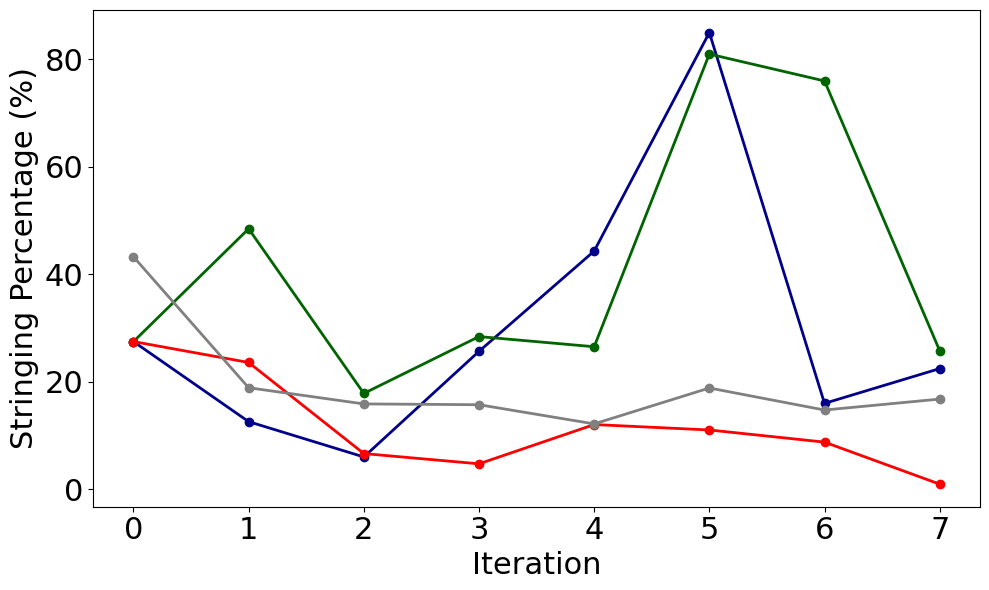

In [4]:
# Define alternating markers
llmrgp_markers = ['s','s','^','s', '^', '^', '^', '^']  # square, triangle
colors = {
    "LLAMBO-L": "darkblue",
    "LLAMBO": "darkgreen",
    "TRAISIENT": "red",
    "BO": "gray",
}

labels = {
    "LLAMBO-L": "LLAMBO-L",
    "LLAMBO": "LLAMBO",
    "TRAISIENT": "TRAISIENT",
    "BO": "BO",
}

plt.figure(figsize=(10, 6))

for method, history in all_history.items():
    iterations = list(range(len(history) - 1))
    stringing = [val[1] for val in history][1:]

    if method == "LLMRGP":
        # Plot the red line first
        plt.plot(iterations, stringing, color=colors[method], linewidth=2.5, label=labels[method])
        for i, (x, y) in enumerate(zip(iterations, stringing)):
            marker = llmrgp_markers[i % len(llmrgp_markers)]
            plt.plot(x, y, marker=marker, color=colors[method], markersize=13, linestyle='None')
    else:
        plt.plot(
            iterations,
            stringing,
            marker='o',
            label=labels[method],
            color=colors[method],
            linewidth=2,
            markersize=6
        )

plt.xlabel("Iteration", fontsize=22)
plt.ylabel("Stringing Percentage (%)", fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

plt.tight_layout()
plt.show()
